In [ ]:
# Select disease to generate projection for

disease = "Congenital Myasthenic Syndromes"

In [4]:
# Provide DataDiVR and multiCore paths

datadivr_path = "./"
multiCore_path = "./"

In [5]:
import os
# Set working directory to the location of DataDiVR

os.chdir(datadivr_path)

##### Constructing visualizations for DataDiVR

In [6]:
import nx2json as nx2j

from networkx.readwrite import json_graph
import json
import networkx as nx
import datetime
import pandas as pd
import random
import numpy as np

import json
import os

import scipy

from networkx.drawing.nx_pydot import graphviz_layout

# If getting an error for the uploaderGraph module, re run the cell.

ModuleNotFoundError: No module named 'nx2json'

: 

In [5]:
import random

def generate_random_colors(num_colors):
    """
    Generate a list of random bright HTML colors.
    
    Parameters:
    - num_colors: Number of colors to generate
    
    Returns:
    - colors: List of random bright HTML colors
    """
    colors = []
    for _ in range(num_colors):
        r = random.randint(128, 255)
        g = random.randint(128, 255)
        b = random.randint(128, 255)
        color = '#%02x%02x%02x' % (r, g, b)
        colors.append(color)
    return colors


In [6]:
from tqdm import tqdm

def build_multilayer_network(edge_list_path, node_metadata_path, add_interlayer_edges=True):
    """
    Build a multilayer network from edge list and node metadata files.
    
    Parameters:
    - edge_list_path: Path to the edge list file
    - node_metadata_path: Path to the node metadata file
    
    Returns:
    - G_union: NetworkX graph object representing the union of all layer graphs
    """
    # Read the edge list
    edgelist_with_att = pd.read_table(edge_list_path, sep='\t', header=0, index_col=False)
    # Remove .tsv string from the column names
    edgelist_with_att.columns = edgelist_with_att.columns.str.replace('.tsv', '')

    print("Edge list:")
    print(edgelist_with_att.head())
    
    # Read the node metadata
    node_metadata = pd.read_table(node_metadata_path, sep='\t', header=0, index_col=False)
    print("Node metadata:")
    print(node_metadata.head())
    
    # Rename columns in node metadata
    node_metadata.rename(columns={'Cluster': 'cluster', 'Color': 'nodecolor'}, inplace=True)
    
    # Initialize an empty graph for the union of all layers
    G_union = nx.Graph()
    
    # Iterate over each layer (column) in the edge list, starting from the third column
    for layer in tqdm(edgelist_with_att.columns[2:], desc="Creating layers..."):
        # Create a subgraph for the current layer
        G_layer = nx.Graph()
        
        # Add edges to the subgraph if the value in the current layer column is 1
        for _, row in edgelist_with_att.iterrows():
            if row[layer] == 1:
                source = f"{row['V1'].split('_')[0]}_{layer}"
                target = f"{row['V2'].split('_')[0]}_{layer}"
                G_layer.add_edge(source, target, layer=layer)
        
        # Add node attributes to the subgraph
        for node in G_layer.nodes:
            base_node = node.split('_')[0]
            if base_node in node_metadata['Node'].values:
                node_attrs = node_metadata[node_metadata['Node'] == base_node].iloc[0].to_dict()
                attrlist = node_attrs
                G_layer.nodes[node]['attrlist'] = attrlist
        # Union the current layer graph with the union graph
        G_union = nx.compose(G_union, G_layer)

    print("Layers created.")
    
    # Create edges between nodes with the same ID in different layers
    if add_interlayer_edges:
        for node in tqdm(G_union.nodes, desc="Adding interlayer edges..."):
            base_node = node.split('_')[0]
            for other_node in G_union.nodes:
                other_base_node = other_node.split('_')[0]
                if base_node == other_base_node:
                    G_union.add_edge(node, other_node, layer='interlayer')

    

    # Get the number of layers
    layers = set(nx.get_edge_attributes(G_union, 'layer').values())
    num_layers = len(layers)

    # Generate random colors for each layer
    colors = generate_random_colors(num_layers)

    # Map layers to colors
    layer_colors = {layer: colors[i] for i, layer in enumerate(layers)}

    # Set edge colors based on the layer they belong to
    edge_colors = {edge: layer_colors[G_union.edges[edge]['layer']] for edge in G_union.edges()}
    nx.set_edge_attributes(G_union, edge_colors, name='linkcolor')

    # Set interlayer edge color
    if add_interlayer_edges:
        for edge in G_union.edges():
            if G_union.edges[edge]['layer'] == 'interlayer':
                G_union.edges[edge]['linkcolor'] = '#07885f'

    # Ensure each node is colored by the cluster
    node_colors = {node: G_union.nodes[node]['attrlist']['nodecolor'] for node in G_union.nodes()}
    nx.set_node_attributes(G_union, node_colors, name='nodecolor')

    # Print the union graph edges with attributes
    #print("Union graph edges with attributes:")
    #print(G_union.edges(data=True))
    print('Multilayer Network created.')
    
    return G_union

In [7]:
def get_3d_positions(G_union, layer_distance=4, vis_algorithm='fruchterman_reingold'):
    """
    Get 3D positions for nodes in a multilayer network using FR layout for each layer.
    
    Parameters:
    - G_union: NetworkX graph object representing the union of all layer graphs
    - layer_distance: Distance between layers in the z-axis
    
    Returns:
    - pos: Dictionary of node positions
    """
    # Extract layers from the node names
    layers = sorted(set(node.split('_')[-1] for node in G_union.nodes))
    
    pos = {}
    layer_z = {layer: i * layer_distance for i, layer in enumerate(layers)}
    
    # Create a dictionary to store the 2D position of each base node
    base_node_positions = {}
    
    # Assign 2D positions using FR layout for the entire graph
    print('Computing 2D for the union graph...')

    # Print current time
    print("Current time: ", datetime.datetime.now().time())

    if vis_algorithm == 'spring':
        pos_2d = nx.spring_layout(G_union, dim=2)
    elif vis_algorithm == 'spectral':
        pos_2d = nx.spectral_layout(G_union, dim=2)
    elif vis_algorithm == 'circular':
        pos_2d = nx.circular_layout(G_union, dim=2)
    elif vis_algorithm == 'kk':
        pos_2d = nx.kamada_kawai_layout(G_union, dim=2)
    elif vis_algorithm == 'spiral':
        pos_2d = nx.spiral_layout(G_union, dim=2)
    elif vis_algorithm == 'shell':
        pos_2d = nx.shell_layout(G_union, dim=2)
    elif vis_algorithm == 'sfdp':
        pos_2d = nx.nx_agraph.graphviz_layout(G_union, prog='sfdp',)
    elif vis_algorithm == 'graph-tool':
        # Use the sfdp layout (Scalable Force-Directed Placement)
        G_gt = nx_to_gt(G_union)
        pos2d = gt.sfdp_layout(G_gt)


    print("Done.")
    print("Current time: ", datetime.datetime.now().time())
    
    # Assign the same 2D position to all nodes of the same origin
    for node in tqdm(G_union.nodes, desc="Assigning 2D positions..."):
        base_node = node.split('_')[0]
        if base_node not in base_node_positions:
            base_node_positions[base_node] = pos_2d[node]
    
    print("2D positions assigned.")

    # Assign 3D positions
    for node in tqdm(G_union.nodes, desc="Assigning 3D positions..."):
        base_node = node.split('_')[0]
        x, y = base_node_positions[base_node]
        layer = node.split('_')[-1]
        z = layer_z[layer]
        pos[node] = (x, y, z)
    
    print("3D positions assigned.")

    return pos

In [8]:
os.chdir(multiCore_path)

In [9]:
edge_list_path = f"Multiplex_DataDiVR/Multiplex_Net_Files/{disease}_Multiplex_Network.tsv"
node_metadata_path = f"Multiplex_DataDiVR/Multiplex_Net_Files/{disease}_Multiplex_Metadata.tsv"

G_union = build_multilayer_network(edge_list_path, node_metadata_path,add_interlayer_edges=True)
posG3D_1_pre = get_3d_positions(G_union, layer_distance=2, vis_algorithm='kk') # For large multilayers, better to use kk with no interlayer edges

G_union.graph["layoutname"] = "Endotypes Multilayer Network"
posG3D_1 = {key: value.tolist() if hasattr(value, 'tolist') else list(value) for key, value in posG3D_1_pre.items()}

#G_union.graph["pos"] = posG3D_1
nx.set_node_attributes(G_union, posG3D_1, name="pos")

Edge list:
       V1       V2  MP  HP  coex_ITI  coex_MSG  ppi
0  CAMKMT   CAMKMT   0   0         0         0    1
1  SLC5A7     SYT2   0   1         0         0    0
2  MEGF10   SLC5A7   0   0         1         0    0
3  KLHL41  CYP26C1   0   1         0         0    0
4  KLHL41   MEGF10   0   1         0         0    0
Node metadata:
     Node  Cluster      Color        Origin
0  ATP2A1        6  #CC33FFFF     RWR Added
1   CHRND        6  #CC33FFFF  Disease Gene
2   STAC3        6  #CC33FFFF     RWR Added
3   SCN4A        6  #CC33FFFF  Disease Gene
4  KLHL41        6  #CC33FFFF     RWR Added


Creating layers...: 100%|██████████| 5/5 [00:00<00:00, 26.28it/s]


Layers created.


Adding interlayer edges...: 100%|██████████| 223/223 [00:00<00:00, 21364.32it/s]


Multilayer Network created.
Computing 2D for the union graph...
Current time:  14:39:52.657210
Done.
Current time:  14:39:53.266360


Assigning 2D positions...: 100%|██████████| 223/223 [00:00<00:00, 945732.85it/s]


2D positions assigned.


Assigning 3D positions...: 100%|██████████| 223/223 [00:00<00:00, 319334.17it/s]

3D positions assigned.


In [10]:
# Create 1 subgraph of the multilayer, where the already present interlayer edges are filtered by the cluster where the node belongs)
# Get the cluster attribute for each node in G_union
node_attrs = nx.get_node_attributes(G_union, 'attrlist')
# Get the clusters
node_clusters = {node: attrs['cluster'] for node, attrs in node_attrs.items()}
# conver the dictionary elemnts to string
#node_clusters = {str(k): str(v) for k, v in node_clusters.items()}


In [11]:
cluster_graphs = {}

# For each cluster, filter the multilayer network to just the nodes included in the cluster
for cluster in set(node_clusters.values()):
    cluster_graph = G_union.copy()
    nodes_to_keep = [node for node in cluster_graph.nodes() if node_clusters[node] == cluster]
    cluster_graphs[cluster] = cluster_graph.subgraph(nodes_to_keep)
    cluster_graphs[cluster].graph["layoutname"] = f"Endotype {cluster}"
    

cluster_graphs = list(cluster_graphs.values())

In [12]:
Graphs_for_VR = [G_union, *cluster_graphs]

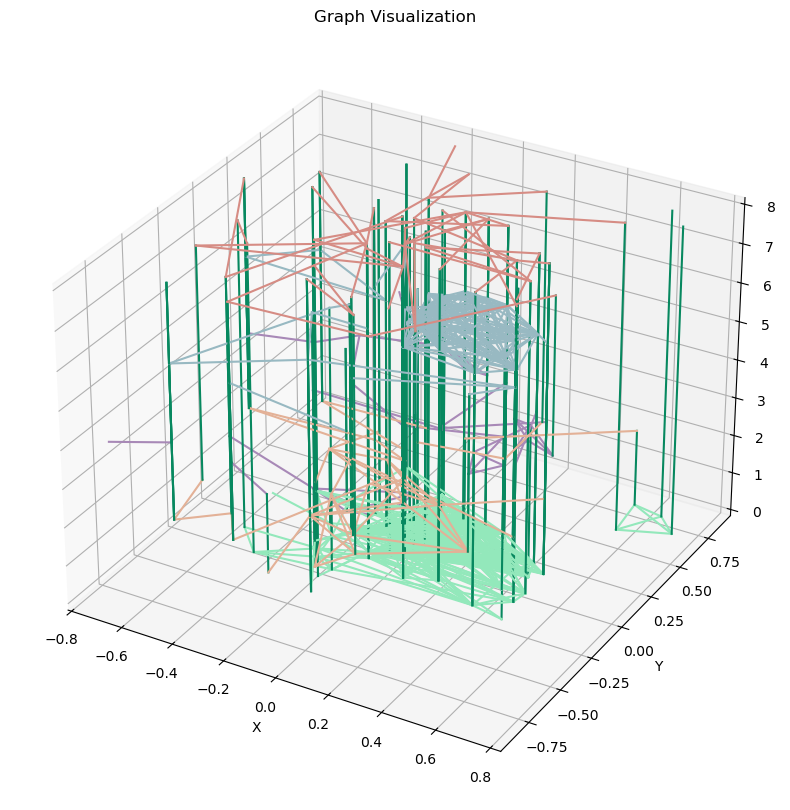

In [13]:
# A simple visualization of 1 endotype

edgelisti = Graphs_for_VR[0].edges

from mpl_toolkits.mplot3d import Axes3D

# Plot the graph

import matplotlib.pyplot as plt
# Plot the graph

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for edge in edgelisti:
    ax.plot([posG3D_1[edge[0]][0], posG3D_1[edge[1]][0]],
            [posG3D_1[edge[0]][1], posG3D_1[edge[1]][1]],
            [posG3D_1[edge[0]][2], posG3D_1[edge[1]][2]], color=G_union.edges[edge]['linkcolor'])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Graph Visualization')
plt.show()

In [14]:
Graphs_for_VR

In [15]:
os.chdir(datadivr_path)

In [16]:
from uploaderGraph import upload_filesJSON
import uploaderGraph

# Add project metadata
Graphs_for_VR = [G_union, *cluster_graphs]
projectname = 'multiCore_' + disease

for Grafos in Graphs_for_VR:
    Grafos.graph['projectname'] = projectname
    Grafos.graph['info'] = disease + "multiCore definition"


nx2j.create_project(Graphs_for_VR)

Creating Project...
Successfully created the directory static/projects/multiCore_Congenital Myasthenic Syndromes 
Project created successfully.
